### Import các thư viện cần thiết

In [1]:
import torch
import torch.nn as nn

from PIL import Image
from torchvision import transforms

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### Đọc ảnh và hiển thị ảnh

In [3]:
img_size = 256

img_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor()
])

def load_image(image_path):
    image = Image.open(image_path)
    image = img_transform(image)
    return image.unsqueeze(0).to(device)

style_img1 = load_image('./Data/style_img.jpg')
style_img2 = load_image('./Data/style_img2.jpg')
content_img = load_image('./Data/content_img.jpg')

In [4]:
content_img.shape

torch.Size([1, 3, 256, 256])

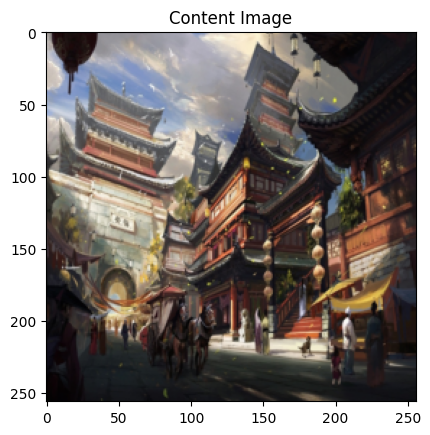

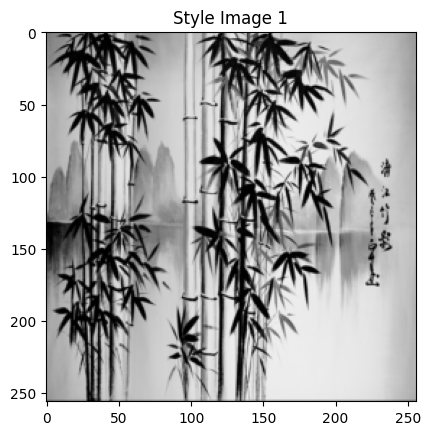

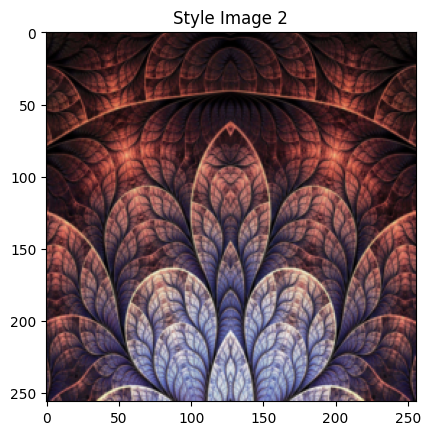

In [5]:
def show_image(image_tensor, title=None):
    image = image_tensor.cpu().clone()
    image = image.squeeze(0)
    image = transforms.ToPILImage()(image)
    plt.imshow(image) 
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# content image
show_image(content_img, title='Content Image')

# Style Image 1
show_image(style_img1, title='Style Image 1')

# Style Image 2
show_image(style_img2, title='Style Image 2')

### Loss Function

#### Content Loss

In [6]:
content_weight = 1
ContentLoss = nn.MSELoss()

#### Style Loss

In [7]:
def gram_matrix(tensor):
    a, b, c, d = tensor.shape
    matrix = tensor.view(a*b, c*d)
    G = torch.mm(matrix, matrix.t())
    return G.div(a * b * c * d)

style_weight = 1e6
StyleLoss = nn.MSELoss()

### Model

In [8]:
from torchvision.models import vgg19, VGG19_Weights

VGG19Pretrained = vgg19(weights=VGG19_Weights.DEFAULT).features.eval()
VGG19Pretrained.to(device)

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

In [9]:
class Normalization(nn.Module):
    def __init__(self):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
        self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)

    def forward(self, img):
        return (img - self.mean) / self.std

normalization = Normalization().to(device)

C:\Users\FPTSHOP\AppData\Local\Temp\ipykernel_30248\1740699474.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(torch.tensor([0.485, 0.456, 0.406]).to(device)).view(-1, 1, 1)
C:\Users\FPTSHOP\AppData\Local\Temp\ipykernel_30248\1740699474.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(torch.tensor([0.229, 0.224, 0.225]).to(device)).view(-1, 1, 1)


In [10]:
content_layers = ['conv_4']
style_layers = ['conv_1', 'conv_2',
                'conv_3', 'conv_4',
                'conv_5']

In [11]:
# Hàm lấy features
def get_features(pretrained_model, image):
    layers = {
        '0': 'conv_1',
        '5': 'conv_2',
        '10': 'conv_3',
        '19': 'conv_4',
        '28': 'conv_5'
    }
    features = {}
    x = image
    x = normalization(x)
    for name, layer in pretrained_model._modules.items():
        x = layer(x)
        if name in layers: 
            features[layers[name]] = x
    return features

In [12]:
# Hàm kết hợp 2 style theo tỉ lệ 1/4, 3/4
def combine_dual_style(style1_features, style2_features, style_layers, ratio=1/4):
    final_style_features = {}
    for layer in style_layers: 
        st1_feature = style1_features[layer]
        st2_feature = style2_features[layer]

        index_split = int(st1_feature.size()[1] * ratio)
        st_feature = torch.concat([st1_feature[:, :index_split, :, :], st2_feature[:, index_split:, :, :]], dim=1)
        final_style_features[layer] = st_feature
    return final_style_features

In [13]:
# get content features, style features
content_features = get_features(VGG19Pretrained, content_img)
style1_features = get_features(VGG19Pretrained, style_img1)
style2_features = get_features(VGG19Pretrained, style_img2)
final_style_features = combine_dual_style(style1_features, style2_features, style_layers, ratio=1/4)

In [14]:
# Tạo ảnh target và khai báo optimizer
target_image = content_img.clone().requires_grad_(True).to(device)
optimizer = torch.optim.Adam([target_image], lr=2e-2)

In [15]:
STEPS = 500

for step in range(STEPS):
    optimizer.zero_grad()

    with torch.no_grad():
        target_image.clamp_(0, 1) # giữ giá trị trong khoảng [0, 1] để đảm bảo nó luôn nằm trong phạm vi hợp lệ.

    # style transfer
    target_features = get_features(VGG19Pretrained, target_image)
    content_loss = ContentLoss(content_features['conv_4'], target_features['conv_4'])

    style_loss = 0
    for layer_name in style_layers:
        gram_matrix_target = gram_matrix(target_features[layer_name])
        gram_matrix_style = gram_matrix(final_style_features[layer_name])
        style_loss += StyleLoss(gram_matrix_style, gram_matrix_target)

    total_loss = content_loss*content_weight + style_loss*style_weight
    total_loss.backward(retain_graph=True)
    optimizer.step()

    if step % 100 == 99: 
        print(f"Epoch [{step+1}/{STEPS}] Total loss: {total_loss.item():.6f} - Content loss: {content_loss.item():.6f} - Style loss: {style_loss.item():.6f}")
    
    with torch.no_grad():
        target_image.clamp_(0, 1)

Epoch [100/500] Total loss: 100.599777 - Content loss: 23.096069 - Style loss: 0.000078
Epoch [200/500] Total loss: 95.919273 - Content loss: 23.318977 - Style loss: 0.000073
Epoch [300/500] Total loss: 93.433060 - Content loss: 22.499706 - Style loss: 0.000071
Epoch [400/500] Total loss: 92.471390 - Content loss: 22.565926 - Style loss: 0.000070
Epoch [500/500] Total loss: 91.308250 - Content loss: 23.212982 - Style loss: 0.000068


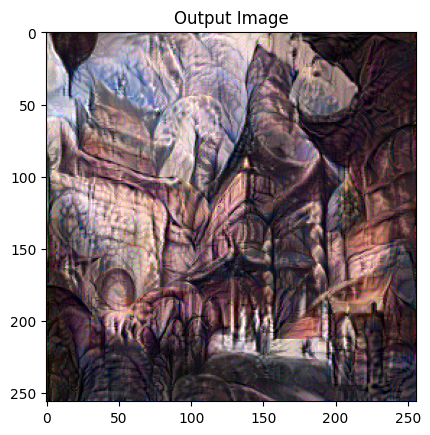

In [16]:
show_image(target_image.cpu().detach(), title='Output Image')